## inception v3 model network/module 파헤치기
 - How to write Inception module: understanding and coding with Keras

## 1. 가장 전형적인 CNN 구성
CNN은 Convolution Layer와 Max Pooling 레이어를 반복적으로 stack을 쌓는 특징 추출(Feature Extraction) 부분과 Fully Connected Layer를 구성하고 마지막 출력층에 Softmax를 적용한 분류(Classification) 부분으로 나뉨

![title](https://taewanmerepo.github.io/2018/01/cnn/cnnexam.png) 

In [ ]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

model = Sequential()
model.add(Conv2D(12, kernel_size=(5, 5), activation='relu', input_shape=(120, 60, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(20, kernel_size=(4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax')) # 4개의 클래스로 분류. (2개클래스면 sigmoid)

출처&parameter 계산법: http://taewan.kim/post/cnn/#5-cnn%EA%B3%BC-fc-neural-network-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-%EB%B9%84%EA%B5%90

## 2. inception module
![title](https://lh3.googleusercontent.com/-JykSjRlbeRo/WxxgppID73I/AAAAAAAABo0/s_8GS7rIsdwY4OjFgyHD9kUJ-0FFpwM7gCLcBGAs/s640/inception.png)

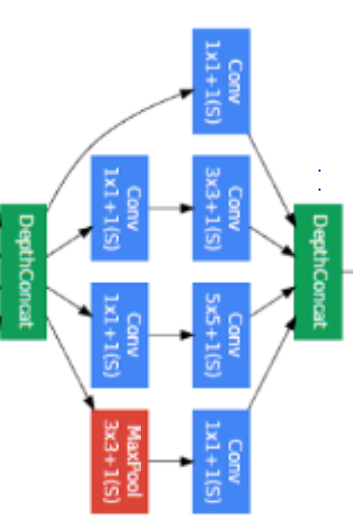

In [1]:
# naive version of inception module

import keras
from keras.layers import Dense, Input, Conv2D, Flatten, concatenate, MaxPooling2D
from keras.models import Model

def naive_inception(inputs):
    towerOne = Conv2D(6, (1,1), activation='relu', padding='same')(inputs)
    towerTwo = Conv2D(6, (3,3), activation='relu', padding='same')(inputs)
    towerThree = Conv2D(6, (5,5), activation='relu', padding='same')(inputs)
    x = concatenate([towerOne, towerTwo, towerThree], axis=3)
    return x

Using TensorFlow backend.


In [2]:
# Inception module with dimension reduction

def dimension_reduction_inception(inputs):
    tower_one = MaxPooling2D((3,3), strides=(1,1), padding='same')(inputs)
    tower_one = Conv2D(6, (1,1), activation='relu', border_mode='same')(tower_one)

    tower_two = Conv2D(6, (1,1), activation='relu', border_mode='same')(inputs)
    tower_two = Conv2D(6, (3,3), activation='relu', border_mode='same')(tower_two)

    tower_three = Conv2D(6, (1,1), activation='relu', border_mode='same')(inputs)
    tower_three = Conv2D(6, (5,5), activation='relu', border_mode='same')(tower_three)
    x = concatenate([towerOne, towerTwo, towerThree], axis=3)
    return x

이 두가지 module을 적절히 stack하여 새로운 모델을 만들수 있다

In [3]:
# 앞서 정의한 module을 이용하여 새로운 model 만들기
# naive version of Inception module을 이용한 모델

def naive_model(x_train):

    inputs = Input(x_train.shape[1:])

    x = naive_inception(inputs) # naive module 불러오기
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x) 
    predictions = Dense(10, activation='softmax')(x)

    model = Model(input=inputs, output=predictions)

    model.compile(loss=keras.losses.categorical_crossentropy,
                 optimizer=keras.optimizers.SGD(lr=0.0001),
                 metrics=['accuracy'])
    return model

In [4]:
# mnist dataset으로 모델을 학습할 것 - cpu이므로 데이터개수는 2000개로 제한

from keras.datasets import mnist
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape((60000, 28, 28, 1))
y_train = to_categorical(y_train, 10)

# model training
modelA = naive_model(x_train)
modelA.fit(x_train, y_train, epochs=50, shuffle=True,  validation_split=0.1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


C:\Users\YANG\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


Train on 1800 samples, validate on 200 samples
Epoch 1/50
1800/1800 [==============================] - 3s 2ms/step - loss: 9.8994 - accuracy: 0.3444 - val_loss: 7.7765 - val_accuracy: 0.4700
Epoch 2/50
1800/1800 [==============================] - 3s 2ms/step - loss: 6.3770 - accuracy: 0.5794 - val_loss: 6.5302 - val_accuracy: 0.5550
Epoch 3/50
1800/1800 [==============================] - 3s 1ms/step - loss: 5.1488 - accuracy: 0.6567 - val_loss: 5.7590 - val_accuracy: 0.6150
Epoch 4/50
1800/1800 [==============================] - 3s 2ms/step - loss: 4.5227 - accuracy: 0.6989 - val_loss: 5.2204 - val_accuracy: 0.6650
Epoch 5/50
1800/1800 [==============================] - 3s 1ms/step - loss: 4.1800 - accuracy: 0.7289 - val_loss: 4.5657 - val_accuracy: 0.7050
Epoch 6/50
1800/1800 [==============================] - 3s 1ms/step - loss: 4.0380 - accuracy: 0.7378 - val_loss: 4.5389 - val_accuracy: 0.7000
Epoch 7/50
1800/1800 [==============================] - 3s 2ms/step - loss: 3.9408 - accu

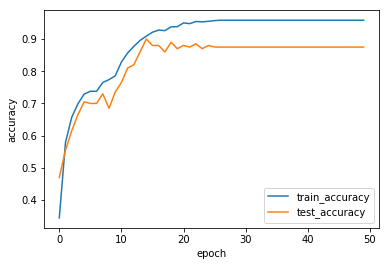

In [7]:
# training 과정 시각화

import matplotlib.pyplot as plt
def show_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()

show_history(modelA.history)

In [ ]:
# dimension reduction module을 이용한 모델

def dimension_reduction_model(x_train):

    inputs = Input(x_train.shape[1:])

    x = dimension_reduction_inception(inputs)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)

    model = Model(input=inputs, output=predictions)

    model.compile(loss=keras.losses.categorical_crossentropy,
                 optimizer=keras.optimizers.SGD(lr=0.0001),
                 metrics=['accuracy'])
    return model

modelB = naive_model(x_train)
modelB.fit(x_train, y_train, epochs=50, shuffle=True,  validation_split=0.1)

C:\Users\YANG\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


Train on 1800 samples, validate on 200 samples
Epoch 1/50
1800/1800 [==============================] - 3s 2ms/step - loss: 8.8267 - accuracy: 0.3906 - val_loss: 6.4848 - val_accuracy: 0.5350
Epoch 2/50
1800/1800 [==============================] - 4s 2ms/step - loss: 5.5556 - accuracy: 0.6083 - val_loss: 6.0661 - val_accuracy: 0.5550
Epoch 3/50
1800/1800 [==============================] - 3s 2ms/step - loss: 4.5441 - accuracy: 0.6844 - val_loss: 5.0211 - val_accuracy: 0.6500
Epoch 4/50
1800/1800 [==============================] - 4s 2ms/step - loss: 4.2170 - accuracy: 0.7111 - val_loss: 4.0137 - val_accuracy: 0.7100
Epoch 5/50
1800/1800 [==============================] - 4s 2ms/step - loss: 3.8818 - accuracy: 0.7339 - val_loss: 3.8515 - val_accuracy: 0.7250
Epoch 6/50
1800/1800 [==============================] - 4s 2ms/step - loss: 3.6946 - accuracy: 0.7517 - val_loss: 4.7252 - val_accuracy: 0.6650
Epoch 7/50
1800/1800 [==============================] - 3s 2ms/step - loss: 3.7317 - accu

In [ ]:
# training 과정 시각화
show_history(modelB.history)

출처: http://marubon-ds.blogspot.com/2018/06/how-to-write-inception-module.html

## 3. Going Deeper with Convolutions
-  **GoogLeNet or Inception v1 module**  
: 앞서 정의한 inception module을 적절히 조합하여 더 깊게 만든 네트워크

![title](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/10/Screenshot-from-2018-10-16-11-56-41.png)

![title](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/10/googlenet.png)

In [ ]:
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import cv2 
import numpy as np 
from keras.datasets import cifar10 
from keras import backend as K 
from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

In [ ]:
import keras
from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf
from keras.datasets import cifar10

In [ ]:
# load the dataset and perform some preprocessing steps

num_classes = 10

def load_cifar10_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

    # Resize training images
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])

    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train, Y_train, X_valid, Y_valid

In [ ]:
X_train, y_train, X_test, y_test = load_cifar10_data(224, 224)

#### 1)  inception module을 parameter만 바꾼뒤 바로 불러오기 위해 먼저 define 해준다
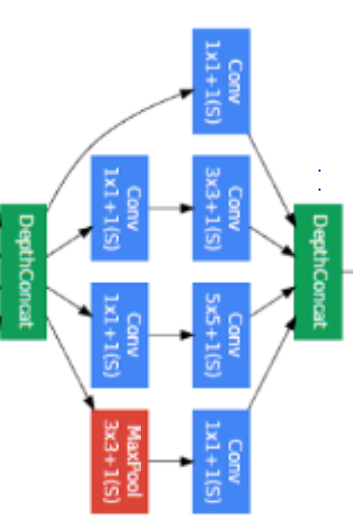

In [41]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [42]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

#### 2)  googleNet architecture 구성

In [43]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

# 앞서 정의한 inception module 불러오기
x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)
# train에 사용할 imageset의 class가 10개 이므로

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)

In [44]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')

In [45]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

#### 3) model training using CIFAR-10 dataset
- CIFAR-10 consists of 60,000 images of 10 classes 

In [24]:
# add a few finishing touches before training model
epochs = 25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_test, [y_test, y_test, y_test]), epochs=epochs, batch_size=256, callbacks=[lr_sc])

In [ ]:
# inception v3로 transfer learning 하는 일련의 과정 파악 - cat/dog 한거랑 비슷함. 한번 더 읽어보기
# https://www.kaggle.com/bmarcos/image-recognition-gender-detection-inceptionv3

출처: https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/

In [ ]:
# inception module

## module concat할때마다 필터 개수가 늘어나야함
## axis = 3 인거는 이미지가 3차원 이므로 / z축 고려
## classifier를 2개 쓰는 이유


def inception_module1(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = AvgPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output


def inception_module2(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=2, name=name)
    
    return output


def inception_module3(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_1x1)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=2, name=name)
    
    return output

In [ ]:
# 필터 사이즈는 신경 안씀. 먼저 구조화 하는것만  

input_layer = Input(shape=(229, 229, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

# 앞서 정의한 inception module 불러오기
## module1
x = inception_module1(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module1(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module1(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module2(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module1(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module1(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module1(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module3(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4b')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)


## 여기서부터 못짜겠음.... 모듈을 다시 짜야하나

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)